In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation/data")

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation


100%|██████████| 714M/714M [00:07<00:00, 94.5MB/s]


In [15]:
# ----------------------------
# Imports & User config
# ----------------------------
import os
import random
from glob import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
import sys
import random
import itertools
print("TF:", tf.__version__, "GPU:", tf.test.gpu_device_name() or "No GPU")




TF: 2.19.0 GPU: /device:GPU:0


In [4]:
# ----------------------------
# User config (adjust here)
# ----------------------------
data_dir = "/content/lgg-mri-segmentation/lgg-mri-segmentation/kaggle_3m"  # change to your path
use_nifti = False
depth = 5
img_size = (128, 128)
batch_size = 4
num_epochs = 12
lr = 1e-3
seed = 42
oversample_factor_if_needed = 3
min_pos_fraction_for_no_oversample = 0.15
save_best_model_path = "best_effidec3d_stable.keras"  # native Keras format

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [6]:
# ----------------------------
# Helpers / dataset builders
# ----------------------------

def list_image_mask_pairs_kaggle(root):
    """
    Search recursively for image/mask pairs in a Kaggle-style 2D dataset.

    Assumes mask files are named with "_mask" in the filename and that the
    corresponding image has the same name without "_mask".

    Args:
        root (str): root directory to search.

    Returns:
        List[Tuple[str, str]]: sorted list of (image_path, mask_path) pairs.
    """
    mask_paths = sorted(glob(os.path.join(root, "**", "*_mask*"), recursive=True))
    pairs = []
    for m in mask_paths:
        im = m.replace("_mask", "")
        if os.path.exists(im):
            pairs.append((im, m))
    return pairs

def build_stacks_from_pairs(pairs, stack_depth=3):
    """
    Build stacks of neighbouring slice file paths.

    Each returned element is a tuple (list_of_image_paths, list_of_mask_paths) where
    lists have length == stack_depth. For edge slices, the first/last slice is repeated
    to keep stack size constant.

    Args:
        pairs (List[Tuple[str,str]]): list of (image_path, mask_path) sorted by slice order.
        stack_depth (int): number of slices to include in a stack (must be odd to be symmetric).

    Returns:
        List[Tuple[List[str], List[str]]]: list with one stack per input slice.
    """
    imgs = [p[0] for p in pairs]
    msks = [p[1] for p in pairs]
    n = len(imgs)
    pad = stack_depth // 2
    stacks = []
    for i in range(n):
        idxs = [min(max(i + j, 0), n - 1) for j in range(-pad, pad + 1)]
        stack_imgs = [imgs[k] for k in idxs]
        stack_msks = [msks[k] for k in idxs]
        stacks.append((stack_imgs, stack_msks))
    return stacks

def load_image_gray(path, resize_to=None):
    """
    Load a single image in grayscale and normalize to [0,1].

    Args:
        path (str): path to image file.
        resize_to (Tuple[int,int] or None): (width, height) to resize to. If None, keeps original size.

    Returns:
        np.ndarray: 2D float32 array with values in [0,1].
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise RuntimeError(f"Failed to read {path}")
    if resize_to is not None:
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_LINEAR)
    img = img.astype(np.float32) / 255.0
    return img

# NIfTI loader if needed
try:
    import nibabel as nib
except Exception:
    nib = None

def load_nifti_vol(path, target_size=None):
    """
    Load a NIfTI volume (using nibabel) and optionally resample to target size.

    The volume is normalized to [0,1] by subtracting minimum and dividing by maximum.

    Args:
        path (str): path to .nii or .nii.gz file.
        target_size (Tuple[int,int,int] or None): target shape (D,H,W) to resample to; uses scipy.ndimage.zoom.

    Returns:
        np.ndarray: float32 volume with shape (D,H,W) and values in [0,1].

    Raises:
        RuntimeError: if nibabel is not installed.
    """
    if nib is None:
        raise RuntimeError("nibabel not installed")
    vol = nib.load(path).get_fdata(dtype=np.float32)
    vol = vol - vol.min()
    if vol.max() > 0:
        vol = vol / vol.max()
    if target_size is not None:
        from scipy.ndimage import zoom
        factors = [t / s for s, t in zip(vol.shape, target_size)]
        vol = zoom(vol, factors, order=1)
    return vol


In [5]:
# diagnostics & oversample helpers
def mask_stats_from_stacks(stacks):
    """
    Compute simple statistics about how many slices contain positive mask pixels.

    Args:
        stacks (List[Tuple[List[str], List[str]]]): stacks as returned by build_stacks_from_pairs.

    Returns:
        dict: {
            'total_slices': total number of slices inspected,
            'positive_slices': number of slices with any mask pixel > 127,
            'pos_fraction': positive_slices / total_slices,
            'median_pos_pixels': median number of positive pixels among positive slices
        }
    """
    positives = 0
    total = 0
    pos_pixel_counts = []
    for _, mask_paths in stacks:
        for mp in mask_paths:
            m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
            if m is None:
                continue
            total += 1
            if (m > 127).any():
                positives += 1
                pos_pixel_counts.append(int((m > 127).sum()))
    return {"total_slices": total,
            "positive_slices": positives,
            "pos_fraction": (positives/total if total>0 else 0.0),
            "median_pos_pixels": int(np.median(pos_pixel_counts) if pos_pixel_counts else 0)}

def oversample_positive_stacks(stacks, oversample_factor=3):
    """
    Oversample stacks that contain any positive mask pixel.

    This helps to balance rare positive slices during training.

    Args:
        stacks (List[Tuple[List[str], List[str]]]): stacks to sample from.
        oversample_factor (int): how many times to duplicate positive stacks.

    Returns:
        List[Tuple[List[str], List[str]]]: new shuffled list with oversampled positives.
    """
    new = []
    for s in stacks:
        img_paths, mask_paths = s
        pos_found = False
        for mp in mask_paths:
            m = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
            if m is not None and (m > 127).any():
                pos_found = True
                break
        if pos_found:
            for _ in range(oversample_factor):
                new.append(s)
        else:
            new.append(s)
    random.shuffle(new)
    return new

# dataset builder with simple augmentations inside generator
def stacks_to_tf_dataset(stacks, depth=5, img_size=(128,128), batch=None, shuffle=False, augment=False):
    """
    Convert stacks of 2D file paths into a tf.data.Dataset yielding (volume, mask) pairs.

    The generator loads each stack of grayscale images, resizes them to img_size,
    stacks them into an array of shape (depth, H, W), thresholds masks to binary,
    optionally applies simple geometric/intensity augmentations that are consistent across the whole stack,
    and yields volumes shaped (depth, H, W, 1) with dtype float32.

    Args:
        stacks (List[Tuple[List[str], List[str]]]): stacks created by build_stacks_from_pairs.
        depth (int): expected depth of each stack (number of slices).
        img_size (Tuple[int,int]): (width, height) to resize each slice to.
        batch (int or None): if provided, dataset is batched by this number.
        shuffle (bool): whether to shuffle dataset using tf.data.Dataset.shuffle.
        augment (bool): whether to apply simple on-the-fly augmentations.

    Returns:
        tf.data.Dataset that yields (volume, mask) pairs:
          - volume: tf.Tensor shape (depth, H, W, 1), dtype tf.float32
          - mask: tf.Tensor shape (depth, H, W, 1), dtype tf.float32
    """
    def generator():
        for img_paths, mask_paths in stacks:
            slices = [load_image_gray(p, resize_to=img_size) for p in img_paths]
            masks = [load_image_gray(p, resize_to=img_size) for p in mask_paths]
            vol = np.stack(slices, axis=0).astype(np.float32)  # (D,H,W)
            mvol = np.stack(masks, axis=0).astype(np.float32)
            mvol = (mvol > 0.5).astype(np.float32)
            # simple augmentations applied to whole stack for consistency
            if augment:
                if random.random() < 0.5:
                    vol = np.flip(vol, axis=2)
                    mvol = np.flip(mvol, axis=2)
                if random.random() < 0.3:
                    vol = np.flip(vol, axis=1)
                    mvol = np.flip(mvol, axis=1)
                k = random.choice([0,0,0,1])
                if k:
                    vol = np.rot90(vol, k, axes=(1,2))
                    mvol = np.rot90(mvol, k, axes=(1,2))
                if random.random() < 0.5:
                    factor = 1.0 + (random.random() - 0.5) * 0.2
                    vol = np.clip(vol * factor, 0.0, 1.0)
            vol = vol[..., np.newaxis]
            mvol = mvol[..., np.newaxis]
            yield vol.astype(np.float32), mvol.astype(np.float32)

    out_shape = (depth, img_size[0], img_size[1], 1)
    ds = tf.data.Dataset.from_generator(generator,
                                        output_signature=(
                                            tf.TensorSpec(shape=out_shape, dtype=tf.float32),
                                            tf.TensorSpec(shape=out_shape, dtype=tf.float32)
                                        ))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(2048, max(1, len(stacks))))
    if batch:
        ds = ds.batch(batch)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

def nifti_pairs_to_tf_dataset(pairs, target_size=None, batch=None, shuffle=False):
    """
    Create a tf.data.Dataset from NIfTI image/mask pairs.

    Each yielded example is a (volume, mask) pair where both are float32 tensors
    with shape (D,H,W,1). Masks are thresholded at 0.5 to binary.

    Args:
        pairs (List[Tuple[str,str]]): list of (image_nifti_path, mask_nifti_path).
        target_size (Tuple[int,int,int]): required; resamples volumes to this shape (D,H,W).
        batch (int or None): batch size; if provided the dataset is batched.
        shuffle (bool): whether to shuffle the dataset.

    Returns:
        tf.data.Dataset yielding (volume, mask) tensors.
    """
    def generator():
        for im_path, m_path in pairs:
            vol = load_nifti_vol(im_path, target_size=target_size)
            mvol = load_nifti_vol(m_path, target_size=target_size)
            mvol = (mvol > 0.5).astype(np.float32)
            vol = vol[..., np.newaxis]
            mvol = mvol[..., np.newaxis]
            yield vol.astype(np.float32), mvol.astype(np.float32)
    if target_size is None:
        raise ValueError("For NIfTI dataset set target_size=(D,H,W)")
    out_shape = (target_size[0], target_size[1], target_size[2], 1)
    ds = tf.data.Dataset.from_generator(generator,
                                        output_signature=(
                                            tf.TensorSpec(shape=out_shape, dtype=tf.float32),
                                            tf.TensorSpec(shape=out_shape, dtype=tf.float32)
                                        ))
    if shuffle:
        ds = ds.shuffle(buffer_size=min(1024, max(1, len(pairs))))
    if batch:
        ds = ds.batch(batch)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


In [7]:
# ----------------------------
# Prepare data and splits
# ----------------------------
if use_nifti:
    image_files = sorted(glob(os.path.join(data_dir, "**", "*.nii*"), recursive=True))
    pairs = []
    for im in image_files:
        m_guess = im.replace("image", "mask")
        if os.path.exists(m_guess):
            pairs.append((im, m_guess))
    print("Found NIfTI pairs:", len(pairs))
    dataset_full_pairs = pairs
    total = len(dataset_full_pairs)
    idxs = list(range(total))
    random.shuffle(idxs)
    train_idx = idxs[:int(0.7*total)]
    val_idx = idxs[int(0.7*total): int(0.85*total)]
    test_idx = idxs[int(0.85*total):]

    train_pairs = [dataset_full_pairs[i] for i in train_idx]
    val_pairs = [dataset_full_pairs[i] for i in val_idx]
    test_pairs = [dataset_full_pairs[i] for i in test_idx]

    train_ds = nifti_pairs_to_tf_dataset(train_pairs, target_size=None, batch=batch_size, shuffle=True)
    val_ds = nifti_pairs_to_tf_dataset(val_pairs, target_size=None, batch=batch_size, shuffle=False)
    test_ds = nifti_pairs_to_tf_dataset(test_pairs, target_size=None, batch=1, shuffle=False)

    train_n = len(train_pairs)
    val_n = len(val_pairs)
    test_n = len(test_pairs)

else:
    pairs = list_image_mask_pairs_kaggle(data_dir)
    if len(pairs) == 0:
        raise RuntimeError(f"No mask-image pairs found under {data_dir}. Check path and naming.")
    print("Found 2D pairs:", len(pairs))
    stacks = build_stacks_from_pairs(pairs, stack_depth=depth)

    n = len(stacks)
    indices = list(range(n))
    random.shuffle(indices)
    train_idx = indices[:int(0.7*n)]
    val_idx = indices[int(0.7*n): int(0.85*n)]
    test_idx = indices[int(0.85*n):]

    train_stacks = [stacks[i] for i in train_idx]
    val_stacks = [stacks[i] for i in val_idx]
    test_stacks = [stacks[i] for i in test_idx]

    print("Train/Val/Test sizes (samples):", len(train_stacks), len(val_stacks), len(test_stacks))

    # diagnostics
    print("Train mask stats:", mask_stats_from_stacks(train_stacks))
    print("Val mask stats:", mask_stats_from_stacks(val_stacks))
    print("Test mask stats:", mask_stats_from_stacks(test_stacks))

    # oversample if positives are rare
    pos_frac = mask_stats_from_stacks(train_stacks)["pos_fraction"]
    if pos_frac < min_pos_fraction_for_no_oversample:
        print(f"Positive fraction {pos_frac:.3f} < {min_pos_fraction_for_no_oversample}, oversampling positives x{oversample_factor_if_needed}")
        train_stacks = oversample_positive_stacks(train_stacks, oversample_factor=oversample_factor_if_needed)
    else:
        print("No oversampling applied.")

    # Build datasets
    train_ds = stacks_to_tf_dataset(train_stacks, depth=depth, img_size=img_size, batch=batch_size, shuffle=True, augment=True)
    # Make training dataset infinite so model.fit with steps_per_epoch doesn't run out of data
    train_ds = train_ds.repeat()
    val_ds = stacks_to_tf_dataset(val_stacks, depth=depth, img_size=img_size, batch=batch_size, shuffle=False, augment=False)
    test_ds = stacks_to_tf_dataset(test_stacks, depth=depth, img_size=img_size, batch=1, shuffle=False, augment=False)

    train_n = len(train_stacks)
    val_n = len(val_stacks)
    test_n = len(test_stacks)


Found 2D pairs: 3929
Train/Val/Test sizes (samples): 2750 589 590
Train mask stats: {'total_slices': 13750, 'positive_slices': 4786, 'pos_fraction': 0.34807272727272726, 'median_pos_pixels': 1515}
Val mask stats: {'total_slices': 2945, 'positive_slices': 994, 'pos_fraction': 0.33752122241086585, 'median_pos_pixels': 1563}
Test mask stats: {'total_slices': 2950, 'positive_slices': 1084, 'pos_fraction': 0.36745762711864405, 'median_pos_pixels': 1559}
No oversampling applied.


In [8]:
# ----------------------------
# Model: stable UpSampling version
# ----------------------------
def conv_block(x, filters):
    """
    A simple two-convolution block with BatchNormalization and ReLU.

    Args:
        x (tf.Tensor): input tensor.
        filters (int): number of filters for Conv3D layers.

    Returns:
        tf.Tensor: output tensor after two conv layers.
    """
    x = layers.Conv3D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def EffiDec3D_stable(input_shape=(5,128,128,1), base_filters=16, n_classes=1, dropout_rate=0.0):
    """
    Build the EffiDec3D_stable model.

    The architecture is an encoder-decoder with 3D convolutions. Pooling/upsampling
    is performed only in the spatial H/W axes (not across slice/depth axis) by using
    pool_size and upsampling size of (1,2,2). This preserves the number of slices.

    Args:
        input_shape (tuple): shape of input tensor (D,H,W,C), e.g. (5,128,128,1).
        base_filters (int): number of filters in the first level (doubles each downsampling).
        n_classes (int): number of output channels (1 for binary segmentation).
        dropout_rate (float): optional SpatialDropout3D rate applied in the bottleneck.

    Returns:
        tf.keras.Model: compiled model (not yet compiled).
    """
    inputs = keras.Input(shape=input_shape)
    c1 = conv_block(inputs, base_filters)
    p1 = layers.MaxPool3D(pool_size=(1,2,2))(c1)

    c2 = conv_block(p1, base_filters*2)
    p2 = layers.MaxPool3D(pool_size=(1,2,2))(c2)

    c3 = conv_block(p2, base_filters*4)
    p3 = layers.MaxPool3D(pool_size=(1,2,2))(c3)

    b = conv_block(p3, base_filters*8)
    if dropout_rate > 0:
        b = layers.SpatialDropout3D(dropout_rate)(b)

    u3 = layers.UpSampling3D(size=(1,2,2))(b)
    u3 = layers.Conv3D(base_filters*4, kernel_size=3, padding='same')(u3)
    u3 = layers.Concatenate()([u3, c3])
    u3 = conv_block(u3, base_filters*4)

    u2 = layers.UpSampling3D(size=(1,2,2))(u3)
    u2 = layers.Conv3D(base_filters*2, kernel_size=3, padding='same')(u2)
    u2 = layers.Concatenate()([u2, c2])
    u2 = conv_block(u2, base_filters*2)

    u1 = layers.UpSampling3D(size=(1,2,2))(u2)
    u1 = layers.Conv3D(base_filters, kernel_size=3, padding='same')(u1)
    u1 = layers.Concatenate()([u1, c1])
    u1 = conv_block(u1, base_filters)

    out = layers.Conv3D(n_classes, kernel_size=1, activation=None)(u1)
    model = keras.Model(inputs, out, name="EffiDec3D_stable")
    return model


In [9]:
# metrics and losses
eps = 1e-6
bce_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

def dice_metric(y_true, y_pred, eps=1e-6):
    """
    Dice score metric computed on thresholded predictions (0.5).

    Note: this metric thresholds sigmoid(y_pred) at 0.5 before computing Dice.
    It returns the mean Dice across the batch.
    """
    probs = tf.nn.sigmoid(y_pred)
    preds = tf.cast(probs > 0.5, tf.float32)
    preds = tf.reshape(preds, (tf.shape(preds)[0], -1))
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    inter = 2.0 * tf.reduce_sum(preds * y_true_f, axis=1) + eps
    denom = tf.reduce_sum(preds, axis=1) + tf.reduce_sum(y_true_f, axis=1) + eps
    return tf.reduce_mean(inter / denom)

def iou_metric(y_true, y_pred, eps=1e-6):
    """
    Intersection-over-Union (IoU) computed on thresholded predictions.
    """
    probs = tf.nn.sigmoid(y_pred)
    preds = tf.cast(probs > 0.5, tf.float32)
    preds = tf.reshape(preds, (tf.shape(preds)[0], -1))
    y_true_f = tf.reshape(y_true, (tf.shape(y_true)[0], -1))
    inter = tf.reduce_sum(preds * y_true_f, axis=1)
    union = tf.reduce_sum(preds, axis=1) + tf.reduce_sum(y_true_f, axis=1) - inter
    iou = (inter + eps) / (union + eps)
    return tf.reduce_mean(iou)

def voxel_accuracy_metric(y_true, y_pred):
    """
    Simple voxel-wise accuracy between thresholded predictions and ground truth.
    """
    probs = tf.nn.sigmoid(y_pred)
    preds = tf.cast(probs > 0.5, tf.float32)
    eq = tf.cast(tf.equal(preds, y_true), tf.float32)
    return tf.reduce_mean(eq)

def weighted_bce_dice_loss(pos_weight=3.0):
    """
    Combined loss: weighted binary cross-entropy (logits) + soft Dice loss computed on probabilities.

    Weighted BCE uses tf.nn.weighted_cross_entropy_with_logits for handling class imbalance.
    Loss = 0.4 * weighted_BCE + 0.6 * DiceLoss
    """
    def loss(y_true, y_pred):
        logits = y_pred
        y_true_f = tf.cast(y_true, tf.float32)
        wc = tf.nn.weighted_cross_entropy_with_logits(labels=y_true_f, logits=logits, pos_weight=pos_weight)
        bce_loss = tf.reduce_mean(wc)
        probs = tf.nn.sigmoid(logits)
        probs_flat = tf.reshape(probs, (tf.shape(probs)[0], -1))
        y_flat = tf.reshape(y_true_f, (tf.shape(y_true_f)[0], -1))
        inter = 2.0 * tf.reduce_sum(probs_flat * y_flat, axis=1) + eps
        denom = tf.reduce_sum(probs_flat, axis=1) + tf.reduce_sum(y_flat, axis=1) + eps
        dloss = 1.0 - tf.reduce_mean(inter / denom)
        return 0.4 * bce_loss + 0.6 * dloss
    return loss


In [10]:
# ----------------------------
# Build and compile model
# ----------------------------
input_shape = (depth, img_size[0], img_size[1], 1)
model = EffiDec3D_stable(input_shape=input_shape, base_filters=16, n_classes=1, dropout_rate=0.05)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
              loss=weighted_bce_dice_loss(pos_weight=4.0),
              metrics=[voxel_accuracy_metric, iou_metric, dice_metric])
model.summary()


Model: "EffiDec3D_stable"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 128,    │          0 │ -                 │
│ (InputLayer)        │ 128, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 128,    │        448 │ input_layer[0][0] │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 5, 128,    │         64 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 5, 128,    │          0 │ batch_normalizat… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 128,    │      6,928 │ re_lu[0][0]       │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 128,    │         64 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 5, 128,    │          0 │ batch_normalizat… │
│                     │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 5, 64, 64, │          0 │ re_lu_1[0][0]     │
│ (MaxPooling3D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 5, 64, 64, │     13,856 │ max_pooling3d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64, 64, │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 5, 64, 64, │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 5, 64, 64, │     27,680 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 64, 64, │        128 │ conv3d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 5, 64, 64, │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 5, 32, 32, │          0 │ re_lu_3[0][0]     │
│ (MaxPooling3D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 5, 32, 32, │     55,360 │ max_pooling3d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 32, 32, │        256 │ conv3d_4[0][0]  

 Total params: 1,607,665 (6.13 MB)

 Trainable params: 1,606,257 (6.13 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [11]:
# ----------------------------
# Callbacks
# ----------------------------
# NOTE: some TF versions do not accept save_format kw in ModelCheckpoint (TypeError).
# Remove save_format and rely on the file extension (.keras) to pick the format.
cb_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=save_best_model_path,
    monitor='val_dice_metric',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
cb_early = keras.callbacks.EarlyStopping(monitor='val_dice_metric', mode='max', patience=8, restore_best_weights=True)
cb_reduce = keras.callbacks.ReduceLROnPlateau(monitor='val_dice_metric', mode='max', factor=0.5, patience=4, min_lr=1e-6, verbose=1)

# ----------------------------
# Train
# ----------------------------
# compute stable steps_per_epoch and val_steps
train_steps = max(1, int(np.ceil(train_n / batch_size)))
val_steps = max(1, int(np.ceil(val_n / batch_size)))

print("train_n:", train_n, "batch_size:", batch_size, "train_steps:", train_steps, "val_steps:", val_steps)
print("Note: training dataset is repeated (infinite) so pass steps_per_epoch to model.fit to avoid exhaustion.")

history = model.fit(train_ds,
                    epochs=num_epochs,
                    steps_per_epoch=train_steps,
                    validation_data=val_ds,
                    validation_steps=val_steps,
                    callbacks=[cb_checkpoint, cb_early, cb_reduce],
                    verbose=1)


train_n: 2750 batch_size: 4 train_steps: 688 val_steps: 148
Note: training dataset is repeated (infinite) so pass steps_per_epoch to model.fit to avoid exhaustion.
Epoch 1/12
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - dice_metric: 0.2756 - iou_metric: 0.2438 - loss: 0.6327 - voxel_accuracy_metric: 0.9707
Epoch 1: val_dice_metric improved from -inf to 0.28384, saving model to best_effidec3d_stable.keras
688/688 ━━━━━━━━━━━━━━━━━━━━ 177s 207ms/step - dice_metric: 0.2757 - iou_metric: 0.2438 - loss: 0.6327 - voxel_accuracy_metric: 0.9707 - val_dice_metric: 0.2838 - val_iou_metric: 0.2440 - val_loss: 0.5839 - val_voxel_accuracy_metric: 0.9709 - learning_rate: 0.0010
Epoch 2/12
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - dice_metric: 0.3058 - iou_metric: 0.2661 - loss: 0.5757 - voxel_accuracy_metric: 0.9785
Epoch 2: val_dice_metric did not improve from 0.28384
688/688 ━━━━━━━━━━━━━━━━━━━━ 123s 178ms/step - dice_metric: 0.3058 - iou_metric: 0.2661 - loss: 0.5757 - voxel_accuracy_metric: 0

Plotting training history...


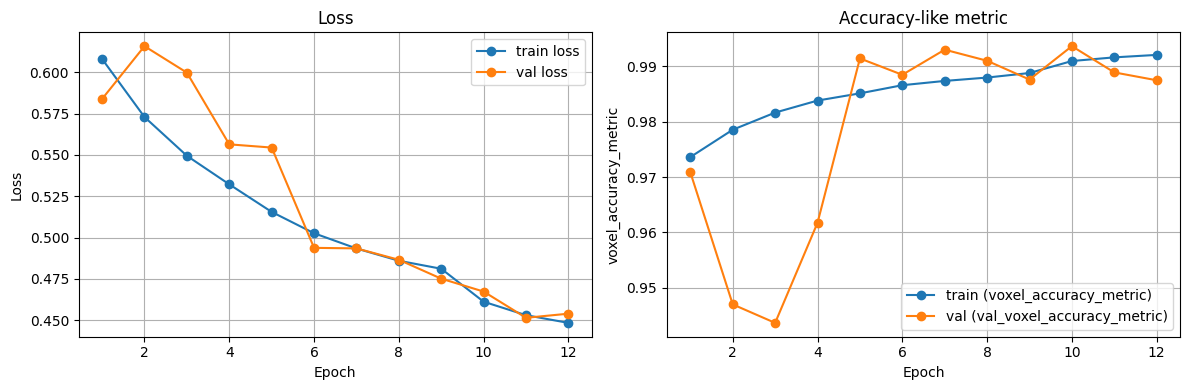

In [12]:
# ----------------------------
# Post-training evaluation & visualization
# ----------------------------
# (This cell assumes model, history, test_ds, test_n, test_stacks/test_pairs exist in scope.

# sklearn may not be installed in the runtime yet
try:
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
except Exception:
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "scikit-learn"])
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras

# helper: sigmoid
def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# 1) Plot training/validation loss and "accuracy" curves ------------------------------------------------
def plot_history(history, save_path=None):
    h = history.history
    epochs = range(1, len(h.get('loss', [])) + 1)

    # find an "accuracy-like" metric in history
    acc_key = None
    acc_candidates = ['voxel_accuracy_metric', 'accuracy', 'voxel_accuracy', 'acc', 'binary_accuracy']
    for k in acc_candidates:
        if k in h:
            acc_key = k
            break

    fig, axes = plt.subplots(1, 2 if acc_key else 1, figsize=(12, 4))

    # loss plot
    ax_loss = axes[0] if acc_key else axes
    ax_loss.plot(epochs, h['loss'], label='train loss', marker='o')
    if 'val_loss' in h:
        ax_loss.plot(epochs, h['val_loss'], label='val loss', marker='o')
    ax_loss.set_title('Loss')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_loss.legend()
    ax_loss.grid(True)

    # accuracy plot if available
    if acc_key:
        ax_acc = axes[1]
        ax_acc.plot(epochs, h[acc_key], label=f'train ({acc_key})', marker='o')
        val_acc_key = 'val_' + acc_key if ('val_' + acc_key) in h else None
        if val_acc_key:
            ax_acc.plot(epochs, h[val_acc_key], label=f'val ({val_acc_key})', marker='o')
        ax_acc.set_title('Accuracy-like metric')
        ax_acc.set_xlabel('Epoch')
        ax_acc.set_ylabel(acc_key)
        ax_acc.legend()
        ax_acc.grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

print("Plotting training history...")
try:
    plot_history(history, save_path="training_history.png")
except Exception as e:
    print("Failed to plot history:", e)

In [13]:



#  Print final training/validation loss & accuracy (from history) ------------------------------------
def last_metric_from_history(history, metric_names):
    h = history.history
    for m in metric_names:
        if m in h:
            return h[m][-1], m
    return None, None

loss_last, _ = last_metric_from_history(history, ['loss'])
val_loss_last, _ = last_metric_from_history(history, ['val_loss'])
acc_last, acc_key = last_metric_from_history(history, ['voxel_accuracy_metric', 'accuracy', 'voxel_accuracy', 'acc', 'binary_accuracy'])
val_acc_last, _ = last_metric_from_history(history, ['val_' + acc_key]) if acc_key else (None, None)

print("\nFinal metrics from history:")
if loss_last is not None:
    print(f"  Training loss: {loss_last:.6f}")
if val_loss_last is not None:
    print(f"  Validation loss: {val_loss_last:.6f}")
if acc_last is not None:
    print(f"  Training {acc_key}: {acc_last:.6f}")
if val_acc_last is not None:
    print(f"  Validation {acc_key}: {val_acc_last:.6f}")




Final metrics from history:
  Training loss: 0.448392
  Validation loss: 0.453958
  Training voxel_accuracy_metric: 0.992080
  Validation voxel_accuracy_metric: 0.987496


In [16]:

#  Evaluate on test set (full metrics) ----------------------------------------------------------------
print("\nEvaluating model on test set...")
# number of steps for evaluation: if test_n available use it, else try to infer
test_steps = None
if 'test_n' in globals() and test_n is not None:
    test_steps = int(math.ceil(test_n / (getattr(globals().get('test_ds'), '_batch_size', 1) or 1)))
# safer: try to evaluate without steps (tf will iterate until exhaustion)
try:
    eval_results = model.evaluate(test_ds, verbose=1)
    # map eval results to their names
    metrics_names = model.metrics_names
    if isinstance(eval_results, list):
        print("\nTest evaluation results:")
        for n, v in zip(metrics_names, eval_results):
            print(f"  {n}: {v:.6f}")
    else:
        print(f"  {metrics_names[0]}: {eval_results:.6f}")
except Exception as e:
    print("model.evaluate failed or requires steps. Attempting evaluate with steps if test_n exists...", e)
    if 'test_n' in globals() and test_n is not None:
        batch_size = getattr(globals().get('test_ds'), '_batch_size', 1) or 1
        steps = int(math.ceil(test_n / batch_size))
        eval_results = model.evaluate(test_ds, steps=steps, verbose=1)
        metrics_names = model.metrics_names
        for n, v in zip(metrics_names, eval_results):
            print(f"  {n}: {v:.6f}")
    else:
        print("Could not evaluate test set automatically. Provide test_n or call model.evaluate manually.")




Evaluating model on test set...
590/590 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - dice_metric: 0.5138 - iou_metric: 0.4675 - loss: 0.5462 - voxel_accuracy_metric: 0.9912

Test evaluation results:
  loss: 0.537677
  compile_metrics: 0.991458


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Computing per-slice classification report & confusion matrix on the test set...

Classification report (per-slice, positive = any mask pixel > 0):
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72       283
    positive       0.74      0.77      0.75       307

    accuracy                           0.74       590
   macro avg       0.74      0.74      0.74       590
weighted avg       0.74      0.74      0.74       590

Confusion matrix:
 [[199  84]
 [ 71 236]]


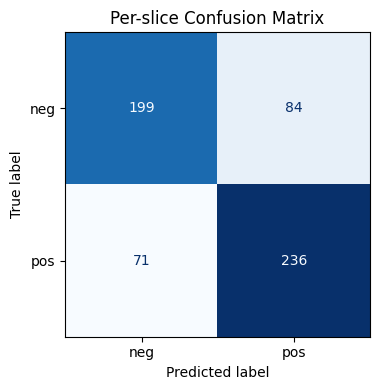

In [17]:

# Per-slice classification report & confusion matrix -------------------------------------------------
# We'll treat a "slice" (stack) as positive if any pixel in the mask is positive.
print("\nComputing per-slice classification report & confusion matrix on the test set...")

y_true_flags = []
y_pred_flags = []
all_y_true_masks = []   # store for visualizations
all_x_inputs = []       # store inputs (for visualization)
all_y_pred_masks = []

# Iterate through test dataset and collect predictions and labels
# We'll take exactly test_n samples if test_n present, otherwise iterate until exhaustion
max_samples = globals().get('test_n', None)
collected = 0

for batch in test_ds:
    x_batch, y_batch = batch
    # get numpy arrays
    x_np = x_batch.numpy()
    y_np = y_batch.numpy()
    # predict (logits) -> convert to probabilities
    logits = model(x_batch, training=False).numpy()
    probs = _sigmoid(logits)
    preds_bin = (probs > 0.5).astype(np.uint8)

    # for each sample in batch
    for i in range(x_np.shape[0]):
        y_mask = (y_np[i] > 0.5).astype(np.uint8)   # shape (D,H,W,1)
        pred_mask = preds_bin[i].astype(np.uint8)
        # per-slice positivity
        y_pos = int(y_mask.any())
        p_pos = int(pred_mask.any())
        y_true_flags.append(y_pos)
        y_pred_flags.append(p_pos)

        all_y_true_masks.append(y_mask)    # keep for visualization
        all_x_inputs.append(x_np[i])
        all_y_pred_masks.append(pred_mask)

        collected += 1
        if (max_samples is not None) and (collected >= max_samples):
            break
    if (max_samples is not None) and (collected >= max_samples):
        break

if len(y_true_flags) == 0:
    print("No test samples found / collected. Skipping classification report.")
else:
    print("\nClassification report (per-slice, positive = any mask pixel > 0):")
    print(classification_report(y_true_flags, y_pred_flags, target_names=['negative', 'positive']))
    cm = confusion_matrix(y_true_flags, y_pred_flags)
    print("Confusion matrix:\n", cm)

    # show confusion matrix plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    plt.title("Per-slice Confusion Matrix")
    plt.tight_layout()
    plt.show()



Showing example predictions (original, gt mask, predicted mask)...


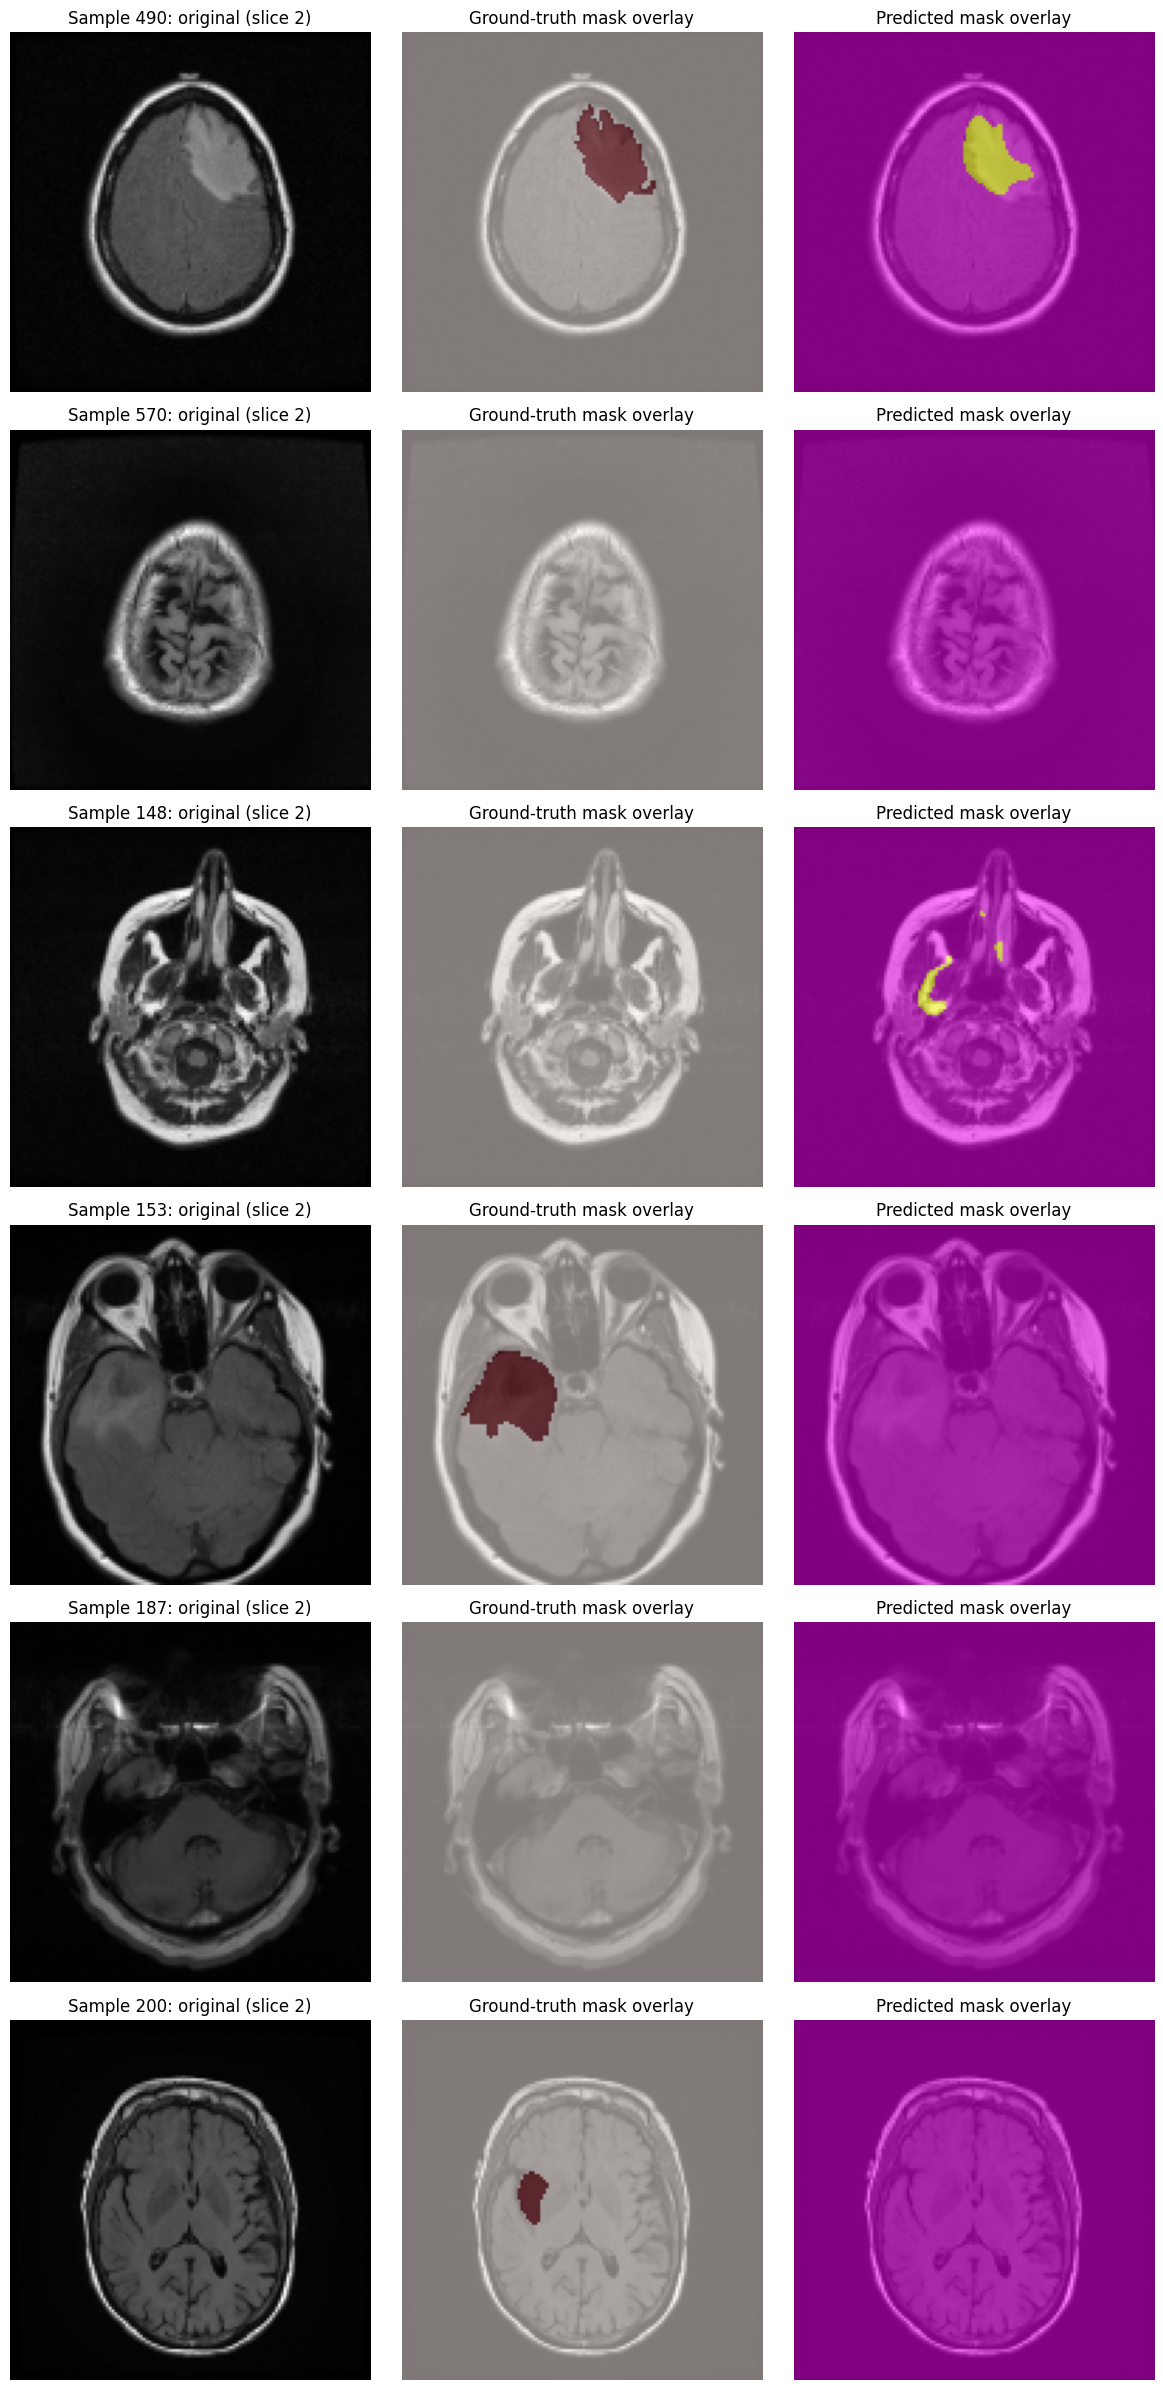

In [18]:


#  Visualize a few test predictions (original, gt mask, predicted mask) --------------------------------
# We'll display the center slice from each stack/volume for clarity.
def show_examples(all_x_inputs, all_y_true_masks, all_y_pred_masks, n_examples=6, seed=42):
    if len(all_x_inputs) == 0:
        print("No samples to show.")
        return
    random.seed(seed)
    indices = list(range(len(all_x_inputs)))
    random.shuffle(indices)
    indices = indices[:min(n_examples, len(indices))]

    ncols = 3
    nrows = len(indices)
    fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    if nrows == 1:
        axs = axs[np.newaxis, ...]
    for r, idx in enumerate(indices):
        x = all_x_inputs[idx]   # shape (D,H,W,1) or (D,H,W,1) for nifti too
        y = all_y_true_masks[idx]
        p = all_y_pred_masks[idx]

        # choose central slice index
        D = x.shape[0]
        mid = D // 2

        img = np.squeeze(x[mid])  # (H,W)
        gt_mask = np.squeeze(y[mid])  # (H,W)
        pred_mask = np.squeeze(p[mid])  # (H,W)

        # Plot original image
        ax = axs[r,0]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Sample {idx}: original (slice {mid})")
        ax.axis('off')

        # Plot GT mask (overlay)
        ax = axs[r,1]
        ax.imshow(img, cmap='gray')
        ax.imshow(gt_mask, cmap='Reds', alpha=0.5)
        ax.set_title("Ground-truth mask overlay")
        ax.axis('off')

        # Plot Pred mask (overlay)
        ax = axs[r,2]
        ax.imshow(img, cmap='gray')
        ax.imshow(pred_mask, cmap='spring', alpha=0.5)
        ax.set_title("Predicted mask overlay")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

print("\nShowing example predictions (original, gt mask, predicted mask)...")
show_examples(all_x_inputs, all_y_true_masks, all_y_pred_masks, n_examples=6)


In [19]:

# Save a few prediction images to disk (optional)
out_dir = "test_predictions_visuals"
os.makedirs(out_dir, exist_ok=True)
n_save = min(12, len(all_x_inputs))
for i in range(n_save):
    x = all_x_inputs[i]
    y = all_y_true_masks[i]
    p = all_y_pred_masks[i]
    D = x.shape[0]
    mid = D // 2
    img = (np.squeeze(x[mid]) * 255.0).astype(np.uint8)
    gt_mask = (np.squeeze(y[mid]) > 0).astype(np.uint8) * 255
    pred_mask = (np.squeeze(p[mid]) > 0).astype(np.uint8) * 255

    # stack three panels horizontally
    H, W = img.shape
    vis = np.zeros((H, W*3, 3), dtype=np.uint8)
    # left: original as gray in RGB
    vis[:, 0:W, :] = np.stack([img, img, img], axis=-1)
    # middle: gt mask over original (red)
    vis[:, W:2*W, :] = np.stack([np.maximum(img, gt_mask), img, img], axis=-1)
    # right: pred mask over original (green)
    vis[:, 2*W:3*W, :] = np.stack([img, np.maximum(img, pred_mask), img], axis=-1)

    fname = os.path.join(out_dir, f"pred_{i}.png")
    try:
        import imageio
        imageio.imwrite(fname, vis)
    except Exception:
        # fallback to PIL
        from PIL import Image
        Image.fromarray(vis).save(fname)

print(f"\nSaved up to {n_save} prediction visuals to {out_dir}")

print("\nDone. You can re-run or tweak thresholds/visualizations as needed.")



Saved up to 12 prediction visuals to test_predictions_visuals

Done. You can re-run or tweak thresholds/visualizations as needed.
